In [1]:
import os
import imageio
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.backends.cudnn as cudnn
import torchvision.utils as vutils
cudnn.benchmark = True

import pytorch3d
import pytorch3d.io


# some utility function for visualization
import utils
from utils.util_3d import init_mesh_renderer, sdf_to_mesh, add_mesh_textures

# some utility function
from utils.qual_util import save_mesh_as_gif
from IPython.display import Image as ipy_image
from IPython.display import display

%reload_ext autoreload
%autoreload 2

In [2]:
from utils.demo_util import get_shape_comp_opt
from utils.demo_util import get_shape_comp_model

""" setup dir """
res_dir = 'test-results'
if not os.path.exists(res_dir): os.mkdir(res_dir)

""" setup opt"""
gpu_id = 0

opt = get_shape_comp_opt(gpu_id=gpu_id)

""" setup different model """
model = get_shape_comp_model(opt)    
model.eval()

""" setup renderer """
dist, elev, azim = 1.7, 20, 110
mesh_renderer = init_mesh_renderer(image_size=256, dist=dist, elev=elev, azim=azim, device=opt.device)

jvermandere
gpuserver-0.geomatics.kuleuven.be
[*] Enc has Attn at i_level, i_block: 3, 0
Working with z of shape (1, 256, 8, 8, 8) = 131072 dimensions.
[*] Dec has Attn at i_level, i_block: 3, 0
[*] VQVAE: weight successfully load from: saved_ckpt/pvqvae-snet-all-LR1e-4-T0.2-rerun-epoch140.pth
[*] Model has been created: Rand-Transformer-Model
[*] "rand_tf" initialized.
[*] weight successfully load from: saved_ckpt/rand_tf-snet_code-all-LR1e-4-clean-epoch200.pth


## SDF Generation

### Unconditional Generation

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

[*] autoregressively inferencing...: 100%|██████████| 512/512 [00:15<00:00, 32.18it/s] 


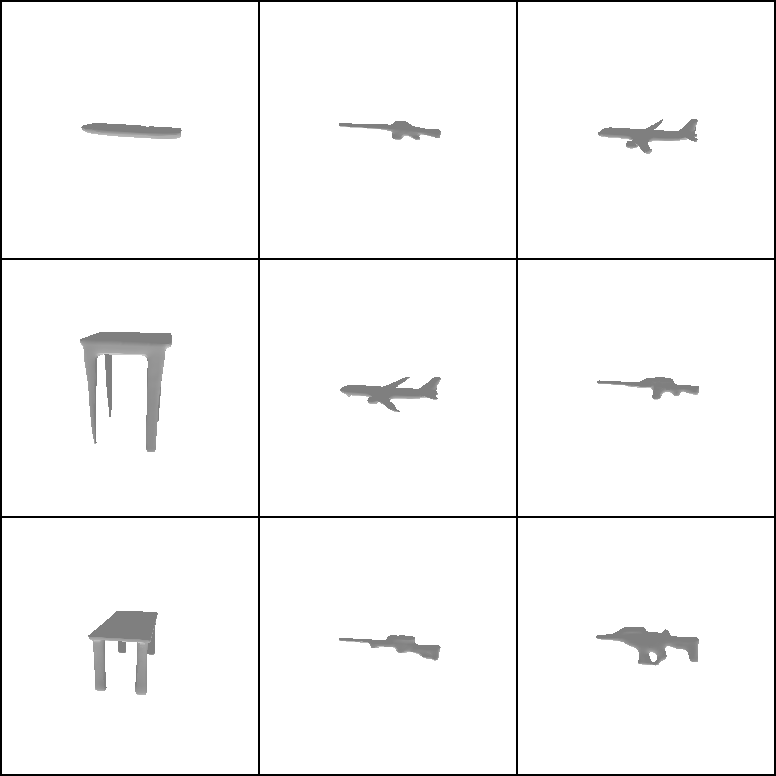

In [3]:
""" Shape completion 1 - unconditional generation """
gen_sdf = model.uncond_gen(bs=9, topk=7)
gen_sdf_as_mesh = sdf_to_mesh(gen_sdf)

# save as gif
gif_name = f'{res_dir}/shape-comp-uncond.gif'
save_mesh_as_gif(mesh_renderer, gen_sdf_as_mesh, nrow=3, out_name=gif_name)

ipy_image(gif_name)

### Shape Completion
The first step is creating an SDF from the mesh

#### Trimesh

In [4]:
import trimesh

mesh = trimesh.load('demo_data/chair_model.obj')
mesh.show()

In [ ]:
from mesh_to_sdf import mesh_to_voxels
import skimage
voxels = mesh_to_voxels(mesh, 64, pad=True)

vertices, faces, normals, _ = skimage.measure.marching_cubes(voxels, level=0)
mesh = trimesh.Trimesh(vertices=vertices, faces=faces, vertex_normals=normals)
mesh.show()

#### Open3d voxelisation

In [ ]:
import open3d as o3d
import numpy as np

mesh = o3d.io.read_triangle_mesh('demo_data/chair_model.obj', True)
mesh.compute_vertex_normals()
mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()), center=mesh.get_center())

In [7]:
voxelDim = 64
voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=1.0/voxelDim)

In [8]:
o3d.visualization.draw_geometries([voxel_grid])

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


### Incomplete SDF Generation
SDF's require watertight meshes for a proper function generation.
Incomplete meshes are not watertight, so we need a different approach

In [9]:
def get_partial_shape_by_range(sdf, input_range, thres=0.2):
    sdf = torch.clamp(sdf, min=-thres, max=thres)
    
    min_x, max_x = input_range['x1'], input_range['x2']
    min_y, max_y = input_range['y1'], input_range['y2']
    min_z, max_z = input_range['z1'], input_range['z2']
    
    bins_x = np.linspace(-1, 1, num=9)
    bins_y = np.linspace(-1, 1, num=9)
    bins_z = np.linspace(-1, 1, num=9)


    # -1: 1, 1: 9
    # find cube idx
    x_inds = np.digitize([min_x, max_x], bins_x)
    y_inds = np.digitize([min_y, max_y], bins_y)
    z_inds = np.digitize([min_z, max_z], bins_z)

    x_inds -= 1
    y_inds -= 1
    z_inds -= 1

    cube_x1, cube_x2 = x_inds
    cube_y1, cube_y2 = y_inds
    cube_z1, cube_z2 = z_inds

    x1, x2 = cube_x1 * 8, (cube_x2) * 8
    y1, y2 = cube_y1 * 8, (cube_y2) * 8
    z1, z2 = cube_z1 * 8, (cube_z2) * 8

    # clone sdf
    x = sdf.clone()
    x_missing = sdf.clone()
    gen_order = torch.arange(512).cuda()
    gen_order = gen_order.view(8, 8, 8)

    x[:, :, :x1, :, :] = 0.2
    gen_order[:cube_x1, :, :] = -1
    x[:, :, x2:, :, :] = 0.2
    gen_order[cube_x2:, :, :] = -1

    x[:, :, :, :y1, :] = 0.2
    gen_order[:, :cube_y1, :] = -1
    x[:, :, :, y2:, :] = 0.2
    gen_order[:, cube_y2:, :] = -1

    x[:, :, :, :, :z1] = 0.2
    gen_order[:, :, :cube_z1] = -1
    x[:, :, :, :, z2:] = 0.2
    gen_order[:, :, cube_z2:] = -1

    x_missing[:, :, x1:x2, y1:y2, z1:z2] = 0.2

    gen_order = gen_order[gen_order != -1]
    gen_order = gen_order.view(-1)

    return {'sdf' : x, 'sdf_missing': x_missing, 'gen_order': gen_order}